In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [73]:
random_state=42

# Data preprocessing

In [219]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [220]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [221]:
df.isna().sum()
# We don't have any NaN

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

([<matplotlib.patches.Wedge at 0x7d61f41d0990>,
 [Text(-0.8823431426537007, 0.6568642010431011, 'False'),
  Text(0.8823431426537006, -0.6568642010431012, 'True')],
 [Text(-0.48127807781110943, 0.3582895642053278, '79.6%'),
  Text(0.4812780778111093, -0.35828956420532787, '20.4%')])

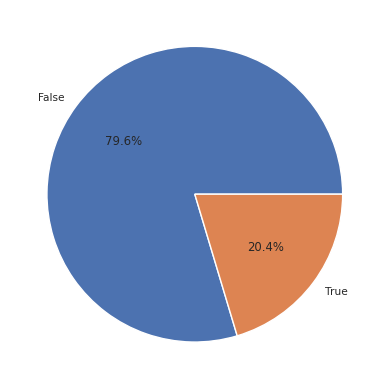

In [222]:
exited = df['Exited'].value_counts()
labels = ['False', 'True']
plt.pie(exited, labels=labels, autopct='%1.1f%%')

In [223]:
# gender = df['Gender'].value_counts()
# labels = ['False', 'True']
# plt.pie(exited, labels=labels, autopct='%1.1f%%')
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [224]:
df = pd.get_dummies(df, dtype=np.int64)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [225]:
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
df.drop(['Balance', 'EstimatedSalary'], axis=1, inplace=True)

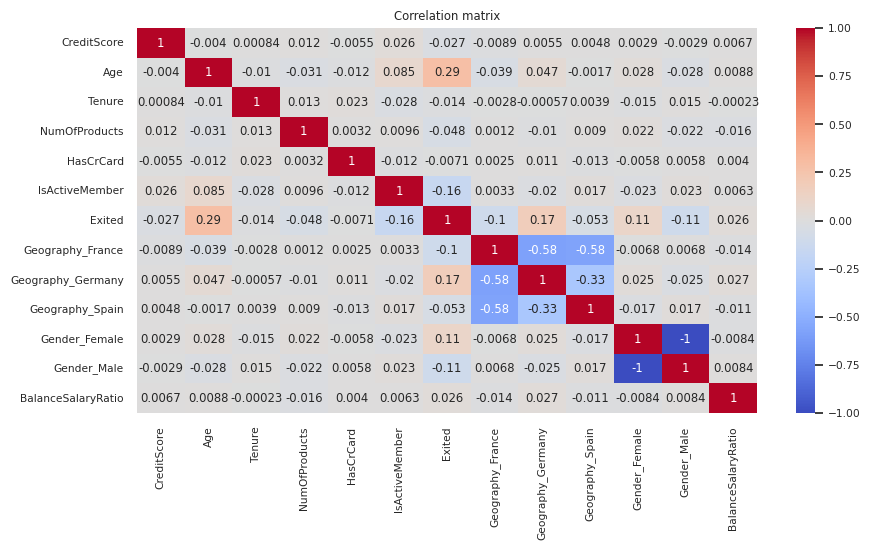

In [226]:
corr_mat = df.corr()
plt.figure(figsize=(10, 5))
sns.set(font_scale=0.7)
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [227]:
Y = df['Exited']
X = df.drop('Exited', axis=1)

In [228]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [229]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

# Estimators

## Random forest

In [110]:
random_forest_sklearn = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 1000],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced'],
    'random_state': [random_state]
}

grid_search = GridSearchCV(estimator=random_forest_sklearn, param_grid=param_grid, n_jobs=4)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 1000],
                         'random_state': [42]})

In [111]:
best_params = grid_search.best_params_
best_params

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'random_state': 42}

In [112]:
y_pred = grid_search.predict(x_test)
roc_auc_score(y_test, y_pred)

0.7147506693837868

In [113]:
accuracy_score(y_test, y_pred)

0.8675

In [114]:
recall_score(y_test, y_pred)

0.4631043256997455

### But what if we try to optimize and take only 200 estimators


In [116]:
random_forest_sklearn = RandomForestClassifier()
param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced'],
    'random_state': [random_state]
}

grid_search_200 = GridSearchCV(estimator=random_forest_sklearn, param_grid=param_grid, n_jobs=4)
grid_search_200.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10], 'n_estimators': [200],
                         'random_state': [42]})

In [120]:
y_pred = grid_search_200.predict(x_test)
roc_auc_score(y_test, y_pred)

0.7134784047527437

In [121]:
accuracy_score(y_test, y_pred)

0.867

In [122]:
recall_score(y_test, y_pred)

0.46055979643765904

200 estimators isn't much worse, but now we'll look at feature importance for 1000 estimators version

In [124]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=[grid_search.best_estimator_.feature_importances_])
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,0.180943,0.284568,0.106296,0.138372,0.02223,0.040039,0.012799,0.023055,0.009751,0.010905,0.0115,0.159542


## SVC

In [91]:
svc = SVC(kernel='poly', degree=7, random_state=random_state)
svc.fit(x_train, y_train)

SVC(degree=7, kernel='poly', random_state=42)

In [92]:
y_pred = svc.predict(x_test)
roc_auc_score(y_test, y_pred)

0.67398278207144

In [93]:
accuracy_score(y_test, y_pred)

0.8545

In [94]:
recall_score(y_test, y_pred)

0.37659033078880405

## XGBoost

In [95]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, 30],
    'learning_rate': [1e-3, 5e-2, 1e-2, 5e-1],
    'random_state': [random_state]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=4)
grid_search_xgb.fit(x_train, y_train)

y_pred = grid_search_xgb.predict(x_test)
roc_auc_score(y_test, y_pred)

0.7064393849427837

In [96]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=[grid_search_xgb.best_estimator_.feature_importances_])
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,0.022885,0.11096,0.021092,0.450964,0.020901,0.181135,0.026441,0.080927,0.026787,0.022009,0.0,0.035898


In [97]:
accuracy_score(y_test, y_pred)

0.8665

In [98]:
recall_score(y_test, y_pred)

0.44274809160305345

In [99]:
grid_search_xgb.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 200,
 'random_state': 42}

## MLP

In [100]:
mlp = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [24, 32, 64, 128], 
    'solver': ['adam'], 
    'alpha': [1e-4, 5e-3, 1e-3], 
    'learning_rate': ['adaptive'], 
    'learning_rate_init': [1e-2, 5e-2, 1e-3], 
    'early_stopping': [True],
    'random_state': [random_state]
}

grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=4)
grid_search_mlp.fit(x_train, y_train)

y_pred = grid_search_mlp.predict(x_test)
roc_auc_score(y_test, y_pred)

0.6941110060786857

In [101]:
accuracy_score(y_test, y_pred)

0.8575

In [102]:
recall_score(y_test, y_pred)

0.42493638676844786

In [103]:
grid_search_mlp.best_params_

{'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': 64,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.05,
 'random_state': 42,
 'solver': 'adam'}

## Logistic regression with L1

In [230]:
logi = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', C=0.01, random_state=random_state)
logi.fit(x_train, y_train)
y_pred = logi.predict(x_test)

In [231]:
accuracy_score(y_test, y_pred)

0.7075

In [232]:
recall_score(y_test, y_pred)

0.7582697201017812

In [233]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=logi.coef_)
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,-0.00726,0.709089,0.0,-0.030646,0.0,-0.376035,-0.009748,0.309592,0.0,0.198236,0.0,0.0


# Conclusion
## Why recall?
    Recall's really important metric for this task because recall shows, how many positives from all positives we've detected and we need to detect as much customers, that'll potentially leave, as possible, and it's better for us because it's more important to retain client than anything else
## Classifier model
- RandomForestClassifier's shown accuracy of 0.87 and recall of 0.46 that means almost half of positives (customer's exited) have been detected
- The best parameters for classifier is:
- 1. class_weight = balanced
  2. max_depth = 20
  3. min_samples_leaf = 1
  4. min_samples_split = 2
  5. n_estimators = 1000
- LogisticRegression's shown best performance among all classifiers on recall (0.75), but accuracy's a bit lower (0.7). I think that this estimator's much better because of high recall increase and relatively small accuracy decrease.
## Features
- Adding new feature "BalanceSalaryRatio" and removing correlating "Balance" and "EstimatedSalary" improves model's performance
- Top 3 most important features are:
- 1. Age (0.28)
  2. CreditScore (0.18)
  3. BalanceSalaryRatio (0.16)
- But if we use Logistic Regression with L1 penalty:
- 1. Age (0.7)
  2. Geography_Germany (means that client's from Germany) (0.3)
  3. IsActiveMember (-0.37) (inverse proportionality)
- All in all, because LogisticRegression's shown better results, hence, I'll base my conclusions on it.
- The most important features are:
- 1. Age
  2. Geography_Germany
  3. IsActiveMember
  
## Experiments
- I tried RandomForest with different n_estimators and here's the results of 2 experiments:
  1. With n_estimators = 200: accuracy = 0.867, recall = 0.46
  2. With n_estimators = 1000: accuracy = 0.8675, recall = 0.46
